In [24]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.signal as ss
import matplotlib.pyplot as plt
import os
from bmtool.util.util import load_nodes_from_paths
from scipy.ndimage import gaussian_filter

from analysis import plot, utils, process, metric # importing analysis module enables import from model folder
from build_input import get_populations, input_pairs_from_file

%matplotlib inline

TRIAL_NAME = "ramp_a0_t1.0_rand"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)
OUTPUT_PATH = "analysis_results"

pop_color = plot.pop_color
pop_names = plot.pop_names

savefig = True
trial_label = utils.get_trial_label(TRIAL_NAME).replace('_', ' ')
if 'LONG' in trial_label:  # special case for long pulse on single assembly
    trial_label = trial_label.replace(' LONG', ' ').replace('ramp', 'long')

trial_label = trial_label[0].upper() + trial_label[1:]
fig_dir = os.path.join(plot.FIG_PATH, 'Fig_3')

### Load data

In [25]:
stim_type, paths, stim_info, config_hp = utils.get_trial_info(TRIAL_PATH)
stimulus_type, isbaseline, isstandard = stim_type
INPUT_PATH, NODE_FILES, SPIKE_FILE = paths
t_stop, stim_setting, stim_params = stim_info

t_start = stim_params['t_start']
on_time, off_time = stim_params['on_time'], stim_params['off_time']

In [26]:
network_name = 'cortex'

node_df = load_nodes_from_paths(NODE_FILES)[network_name]
pop_ids = get_populations(node_df, pop_names, only_id=True)

spikes_df = utils.load_spikes_to_df(SPIKE_FILE, network_name)

### Get population spike rate

In [27]:
# Processing parameters
fs = 400.  # Hz. sampling frequency
time = np.linspace(0, 1000 * t_stop, int(t_stop * fs), endpoint=False)

filt_order = 4  # filter order
filt_cutoff = 8.  # Hz. filter cutoff frequency
# sosfilter = ss.sosfilt  # causal filter
sosfilter = ss.sosfiltfilt  # noncausal filter
sos = ss.butter(N=filt_order, Wn=filt_cutoff, fs=fs, output='sos')

freq_range = (5.0, 70.)  # Hz. Scalogram frequency range

In [28]:
# node ids in assemblies
_, Assembly_ids = input_pairs_from_file(os.path.join(INPUT_PATH, 'Assembly_ids.csv'))
n_assy = len(Assembly_ids)
assy_ids = {a: ids for a, ids in enumerate(Assembly_ids)}

# get assembly groups if obtained from intrinsic assemblies
div_ids_file = os.path.join(INPUT_PATH, 'Division_ids.csv')
isdivision = os.path.isfile(div_ids_file)
if isdivision:
    div_id = pd.read_csv(div_ids_file, index_col='division_id')['assembly_id']
    assy_div = {v: div_id[div_id == v].index.tolist() for v in div_id.unique()}
    assy_ids_disp = [a for ids in assy_div.values() for a in ids]
else:
    assy_ids_disp = list(assy_ids)

# name for PN group that receive common external input
prefix = 'strong' if isdivision else 'random'
assy_names = {a: f'{prefix:s} {a:d}' for a in assy_ids}
assy_names_disp = [assy_names[a] for a in assy_ids_disp]

# indices of assemblies being stimulated
assy_stim = list(range(n_assy)) if isstandard \
    else stim_setting['setting']['assembly_index']

# collect assemblies not stimuluted
rest_assy = assy_ids.keys() - set(assy_stim)
if rest_assy:
    def move_to_rest(assy, idx, name):
        global rest_assy
        assy_ids[idx] = sorted(n for a in assy for n in assy_ids.pop(a))
        assy_names[idx] = name  # idx value has no meaning, just an index
        rest_assy -= assy
    if isdivision:
        for i in div_id[assy_stim].unique():  # intrinsic assemblies being stimulated
            # division assemblies in the same intrinsic assembly but not stimulated
            move_to_rest(set(assy_div[i]) & rest_assy, -1 -i, f'rest in {i}')
    move_to_rest(rest_assy, -n_assy, 'rest')  # remaining assemblies not stimulated
rest_assy_ids = [a for a in assy_ids if a < 0]  # rest assemblies to show

# group names and ids
PN_pop_names = ['CP', 'CS']
ITN_pop_names = ['FSI', 'LTS']
group_ids = {(a, p): sorted(set(pop_ids[p]) & set(ids))
             for a, ids in assy_ids.items() for p in PN_pop_names}
group_names = {(a, p): p + ' ' + assy_names[a] for a in assy_ids for p in PN_pop_names}

In [29]:
grp_rspk = process.group_spike_rate_to_xarray(spikes_df, time, group_ids)
pop_rspk = process.group_spike_rate_to_xarray(spikes_df, time,
    {p: pop_ids[p] for p in ITN_pop_names}, group_dims='population')  # include only ITN
for da in [grp_rspk, pop_rspk]:
    axis = da.spike_rate.dims.index('time')
    # low-pass filter
    da.update(dict(LP_fiilt_spike_rate=xr.zeros_like(da.spike_rate)))
    da.LP_fiilt_spike_rate[:] = sosfilter(sos, da.spike_rate, axis=axis)
    da.attrs.update({'filt_order': filt_order, 'filt_cutoff': filt_cutoff})
    # scalogram
    coords = {k: v for k, v in da.spike_rate.coords.items() if k != 'time'}
    da.update(plot.cwt_spectrogram_xarray(da.spike_rate, da.fs, axis = axis,
        time=da.spike_rate.coords['time'], channel_coords=coords, freq_range=freq_range))

display(grp_rspk)
display(pop_rspk)

<xarray.Dataset>
Dimensions:                      (assembly: 2, population: 2, time: 8400, frequency: 22)
Coordinates:
  * time                         (time) float64 1.25 3.75 ... 2.1e+04 2.1e+04
  * assembly                     (assembly) int64 -9 0
  * population                   (population) object 'CP' 'CS'
  * frequency                    (frequency) float64 5.568 6.25 ... 56.12 63.0
Data variables:
    spike_rate                   (assembly, population, time) float64 0.0 ......
    population_number            (assembly, population) int32 3560 3551 440 449
    LP_fiilt_spike_rate          (assembly, population, time) float64 5.35e-0...
    PSD                          (assembly, population, frequency, time) float64 ...
    cone_of_influence_frequency  (time) float64 1.146e+03 381.8 ... 1.146e+03
Attributes:
    fs:           400.0
    filt_order:   4
    filt_cutoff:  8.0

<xarray.Dataset>
Dimensions:                      (population: 2, time: 8400, frequency: 22)
Coordinates:
  * population                   (population) <U3 'FSI' 'LTS'
  * time                         (time) float64 1.25 3.75 ... 2.1e+04 2.1e+04
  * frequency                    (frequency) float64 5.568 6.25 ... 56.12 63.0
Data variables:
    spike_rate                   (population, time) float64 0.0 0.0 ... 2.5 5.0
    population_number            (population) int32 1200 800
    LP_fiilt_spike_rate          (population, time) float64 -0.2621 ... 4.984
    PSD                          (population, frequency, time) float64 8.96 ....
    cone_of_influence_frequency  (time) float64 1.146e+03 381.8 ... 1.146e+03
Attributes:
    fs:           400.0
    filt_order:   4
    filt_cutoff:  8.0

### Get oscillations

In [30]:
wave_lines = {'gamma': ':', 'beta': '--'}
wave_color = {'gamma': 'tab:red', 'beta': 'tab:purple'}

wave_kwargs = {
    'filter': dict(
        waves = {'gamma': (30.0, 44.0), 'beta': (14.5, 23.5)},
        transform = process.wave_hilbert,
        filt_order = 4
    ),
    'wavelet': dict(
        waves = {'gamma': 37.0, 'beta': 19.0},
        transform = process.wave_cwt,
        bandwidth = 2.0  # time band (inverse to frequency band), sigma of the gaussian envelope for frequency 1.0
    )
}

In [31]:
method = 'wavelet'
grp_waves = process.get_waves(grp_rspk.spike_rate, fs=grp_rspk.fs, **wave_kwargs[method])
pop_waves = process.get_waves(pop_rspk.spike_rate, fs=pop_rspk.fs, **wave_kwargs[method])
waves = grp_waves.wave.values

### Analyze population spike rate

In [32]:
win_extend = 0.4  # extend window by 0.3 sec after stimulus off
windows = 1000. * process.get_stim_windows(on_time, off_time, t_start, t_stop,
                                           win_extend=win_extend)

# assemblies to be plotted in each unique stimulus cycle {unique cycle id: assembly ids}
sel_cyc = None
if stimulus_type == 'long':
    sel_assy = [0, 1, 4]
    sel_cyc = sel_assy
    cyc_to_assy = {i: [assy_stim[j] for j in sel_assy] for i in range(len(assy_stim))}
elif stimulus_type == 'short':
    sel_assy = [0, 1, 4]
    cyc_to_assy = {0: [assy_stim[j] for j in sel_assy]}
else:
    cyc_to_assy = {0: assy_stim}

max_unique_cyc = 2  # maximum number of unique cycles to show
# unique cycle ids to show
if sel_cyc is not None:
    show_unique_cyc = [i for i in sel_cyc if i in cyc_to_assy]
else:
    show_unique_cyc = list(cyc_to_assy.keys())[:max_unique_cyc]
show_assy_ids = {i: cyc_to_assy[i] + rest_assy_ids for i in show_unique_cyc}

# indices of windows with the same stimulus cycles {unique cycle id: cycle numbers}
n_unique_cycle = len(cyc_to_assy)
win_grp_idx = {i: np.arange(i, windows.shape[0], n_unique_cycle)
               for i in range(n_unique_cycle)}

In [33]:
_, grp_rspk_cyc_onff, grp_rspk_cyc_std = process.get_windowed_data(
    grp_rspk.spike_rate, windows, win_grp_idx)
_, _, grp_rspk_cyc_avg = process.get_windowed_data(
    grp_rspk.LP_fiilt_spike_rate, windows, win_grp_idx)
_, _, grp_waves_avg = process.get_windowed_data(grp_waves, windows, win_grp_idx)
_, _, grp_psd_cyc_avg = process.get_windowed_data(grp_rspk.PSD, windows, win_grp_idx)

_, pop_rspk_cyc_onff, pop_rspk_cyc_std = process.get_windowed_data(
    pop_rspk.spike_rate, windows, win_grp_idx)
_, _, pop_rspk_cyc_avg = process.get_windowed_data(
    pop_rspk.LP_fiilt_spike_rate, windows, win_grp_idx)
_, _, pop_waves_avg = process.get_windowed_data(pop_waves, windows, win_grp_idx)
_, _, pop_psd_cyc_avg = process.get_windowed_data(pop_rspk.PSD, windows, win_grp_idx)

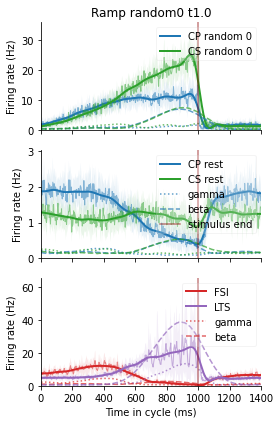

In [34]:
figsize = (4, 2)
show_trials = False
show_raw = True
show_amp = True
leg_row = -2

show_off = int(n_unique_cycle > 1) + 1
if savefig:
    show_off = 1

def plot_rspk(ax, da, p, label, shaded_std=False, **kwargs):
    """Plot spike rate mean and std in shaded region"""
    x = da.sel(population=p)
    if shaded_std:
        ax.fill_between(t_cyc, x.mean_ - x.std_, x.mean_ + x.std_,
                        facecolor=pop_color[p], edgecolor='none', alpha=0.1)
    ax.plot(t_cyc, x.mean_, color=pop_color[p],
            label=label, **kwargs)

def plot_trials(ax, da):
    for i in da.coords['cycle']:
        ax.plot(t_cyc, da.sel(cycle=i), color=pop_color[p], linewidth=1, alpha=0.3)

def plot_amp(ax, da, p, label=False):
    da = da.mean_.sel(population=p)
    line_props = dict(color=pop_color[p], linewidth=1.5, alpha=0.7)
    for w in waves:
        ax.plot(t_cyc, da.sel(wave=w), linestyle=wave_lines[w],
                label=w if label else None, **line_props)

def extract_data(data, onff, unique_cycle, assembly=None):
    sel = {'unique_cycle': unique_cycle}
    if assembly is not None:
        sel['assembly'] = assembly
    return data[onff].sel(**sel)

t_cyc = grp_rspk_cyc_avg[0].time.values
grp_data = [grp_rspk_cyc_avg, grp_rspk_cyc_std, grp_waves_avg]
pop_data = [pop_rspk_cyc_avg, pop_rspk_cyc_std, pop_waves_avg]

for i, show_assy in show_assy_ids.items():
    n_rows = len(show_assy) + 1
    leg_row = leg_row % n_rows
    fig, axs = plt.subplots(n_rows, show_off, squeeze=False,
                          figsize=(figsize[0] * show_off, figsize[1] * n_rows))
    if i == 0:
        fig1 = fig
    for j in range(show_off):
        for row, (a, ax) in enumerate(zip(show_assy, axs[:-1, j])):
            da, da_std, da_wv = [extract_data(d, j, i, a) for d in grp_data]
            for k, p in enumerate(PN_pop_names):
                if show_trials:
                    plot_trials(ax, grp_rspk_cyc_onff[j][i].sel(assembly=a, population=p))
                if show_raw:
                    plot_rspk(ax, da_std, p, None, shaded_std=True, linewidth=1, alpha=0.5)
                plot_rspk(ax, da, p, group_names[(a, p)], linewidth=2)
            for k, p in enumerate(PN_pop_names):
                if show_amp:
                    plot_amp(ax, da_wv, p, label=not k and row == leg_row)
        da, da_std, da_wv = [extract_data(d, j, i) for d in pop_data]
        ax = axs[-1, j]
        for k, p in enumerate(ITN_pop_names):
            if show_trials:
                plot_trials(ax, pop_rspk_cyc_onff[j][i].sel(population=p))
            if show_raw:
                plot_rspk(ax, da_std, p, None, shaded_std=True, linewidth=1, alpha=0.5)
            plot_rspk(ax, da, p, p, linewidth=2)
        for k, p in enumerate(ITN_pop_names):
            if show_amp:
                plot_amp(ax, da_wv, p, label=not k)
    for j, ax in enumerate(axs.ravel()):
        ax.axvline(on_time * 1000, color='darkred', alpha=0.5,
                   label='stimulus end' if j == leg_row * show_off else None)
        ax.set_xlim(0, 1000 * (on_time + win_extend))
        ax.set_ylim(bottom=0)
    for ax in axs[:, 0]:
        ax.set_ylabel('Firing rate (Hz)')
        ax.legend(loc='upper right', framealpha=0.2)
    for j, ax in enumerate(axs[0, :]):
        ax.set_title(('Off' if j else 'On') + f' Cycle {i:d}')
        if savefig:
            ax.set_title(trial_label)
    for ax in axs[-1, :]:
        ax.set_xlabel('Time in cycle (ms)')
    for ax in axs[:-1, :].ravel():
        ax.set_xticklabels('')
    plt.tight_layout()

if savefig:
    plot.savefig(fig1, 'FR-' + trial_label, dir=fig_dir)

plt.show()

### Scalogram

In [35]:
# figsize = (6, 2)

# def iterate_grp_psd(unique_cycle, onff, show_assy):
#     for a in show_assy:
#         for p in PN_pop_names:
#             da = grp_psd_cyc_avg[onff].sel(unique_cycle=unique_cycle, assembly=a, population=p)
#             yield da.mean_.to_dataset(name='PSD'), group_names[(a, p)]
#     for p in ITN_pop_names:
#         da = pop_psd_cyc_avg[onff].sel(unique_cycle=unique_cycle, population=p)
#         yield da.mean_.to_dataset(name='PSD'), p

# for i, show_assy in show_assy_ids.items():
#     n_rows = len(show_assy) * len(PN_pop_names) + len(ITN_pop_names)
#     _, axs = plt.subplots(n_rows, show_off, squeeze=False,
#                           figsize=(figsize[0] * show_off, figsize[1] * n_rows))
#     for j in range(show_off):
#         for k, (da, grp_name) in enumerate(iterate_grp_psd(i, j, show_assy)):
#             ax = axs[k, j]
#             _ = plot.plot_spectrogram(da, log_power=True, ax=ax)
#             ax.set_title(('' if k else ('Off' if j else 'On') + f' Cycle {i:d}\n') + grp_name)
#             ax.set_xlabel('')
#         ax.set_xlabel('Time (ms)')
#     plt.tight_layout()
# plt.show()

### Entrainment

In [36]:
save_plv = True

if save_plv:
    import analysis.pipelines.population_spikes as ps

    PN_phase = process.get_waves(process.combine_spike_rate(
        grp_rspk, dim=['assembly', 'population']).spike_rate,
        fs=grp_rspk.fs, component='pha', **wave_kwargs[method])

    ITN_phase = process.get_waves(process.combine_spike_rate(
        pop_rspk, dim='population').spike_rate,
        fs=grp_rspk.fs, component='pha', **wave_kwargs[method])

    pop_waves = xr.concat([PN_phase, ITN_phase], dim=pd.Index(['PN', 'ITN'], name='wave_population'))

    PN_names = xr.DataArray([f'PN_{a:d}' for a in assy_ids], coords={'assy_id': list(assy_ids)})
    grp_ids = {**dict(zip(PN_names.values, assy_ids.values())), **{p: pop_ids[p] for p in ITN_pop_names}}
    grp_ids = {p: xr.DataArray(ids, dims=p + '_units') for p, ids in grp_ids.items()}
    unit_ids = np.sort(np.concatenate([np.asarray(ids, dtype=int) for ids in grp_ids.values()]))
    tspk = process.get_windowed_spikes(spikes_df, windows, unit_ids)
    axis = pop_waves.dims.index('time')
    pop_plv = metric.phase_locking_value(process.get_spike_phase(pop_waves, pop_waves.time, tspk, axis=axis))
    pop_plv = xr.DataArray(pop_plv, coords=dict(
        unit_id=unit_ids, **{k: v for k, v in pop_waves.coords.items() if k != 'time'}))
    plv_ds = xr.Dataset({'PLV': pop_plv, 'PN_names': PN_names, **grp_ids})
    plv_ds.to_netcdf(os.path.join(ps.FR_ENTR_PATH, TRIAL_NAME + '.nc'))

#### PNs

In [37]:
if not save_plv:
    PN_phase = process.get_waves(process.combine_spike_rate(
        grp_rspk, dim=['assembly', 'population']).spike_rate,
        fs=grp_rspk.fs, component='pha', **wave_kwargs[method])

    assy_tspk = {a: process.get_windowed_spikes(spikes_df, windows, ids) for a, ids in assy_ids.items()}
    assy_plv = {w: {a: metric.phase_locking_value(
        process.get_spike_phase(PN_phase.sel(wave=w), PN_phase.time, t))
        for a, t in assy_tspk.items()} for w in waves}

In [38]:
if not save_plv:
    bargap = 0.2
    bw = (1 - bargap) / waves.size
    box_kwargs = dict(widths=bw, showmeans=True, meanline=True, patch_artist=True,
        showfliers=False, showcaps=True, whiskerprops={'color':'k'}, 
        meanprops=dict(linestyle='-', color='orange'),
        medianprops=dict(linestyle='-', color='g'))
    pos = np.arange(len(assy_ids))
    labels = [assy_names[a] for a in assy_ids]

    figsize = (1, 3)
    _, ax = plt.subplots(figsize=(figsize[0] * (len(assy_ids) + 1), figsize[1]))
    bp = {}
    for i, (w, plv) in enumerate(assy_plv.items()):
        b = ax.boxplot(plv.values(), positions=pos + (i + .5) * bw, **box_kwargs)['boxes']
        for patch in b:
            patch.set_facecolor(wave_color[w])
            patch.set_edgecolor('none')
        bp[w] = b[0]
    ax.set_xticks(pos + (1 - bargap) / 2)
    ax.set_xticklabels(labels)
    ax.set_xlim(-bargap / 2, len(assy_ids) - bargap / 2)
    ax.set_ylabel('Phase locking value')
    ax.legend(bp.values(), bp.keys(), loc='upper right', framealpha=0.2)
    plt.tight_layout()
    plt.show()

#### ITNs

In [39]:
if not save_plv:
    ITN_phase = process.get_waves(pop_rspk.spike_rate,
        fs=pop_rspk.fs, component='pha', **wave_kwargs[method])

    ITN_tspk = {p: process.get_windowed_spikes(spikes_df, windows, pop_ids[p]) for p in ITN_pop_names}
    ITN_plv = {w: {p: metric.phase_locking_value(
        process.get_spike_phase(ITN_phase.sel(wave=w, population=p), ITN_phase.time, t))
        for p, t in ITN_tspk.items()} for w in waves}

In [40]:
if not save_plv:
    plv_df = {}
    for w, plv in assy_plv.items():
        plv_df[w, 'PN'] = np.concatenate(list(plv.values()))
    for w, plv in ITN_plv.items():
        for p, v in plv.items():
            plv_df[w, p] = v
    plv_df = {wp: dict(median=np.median(plv), mean=plv.mean(), stdev=plv.std()) for wp, plv in plv_df.items()}
    plv_df = pd.DataFrame.from_dict(plv_df, orient='index')
    plv_df = plv_df.loc[pd.MultiIndex.from_product((waves, ['PN'] + ITN_pop_names))]
    with pd.option_context('display.float_format', '{:.3f}'.format):
        display(plv_df)
    print(plv_df.to_string(float_format='{:.3f}'.format, index=False, header=False))

### Population trajectory

In [41]:
marker_kwargs = dict(
    marker_times = np.array((t_cyc[0], 1000 * on_time, t_cyc[-1])),
    marker_names = ['stimulus on', 'stimulus off', 'cycle end'],
    marker_props = dict(
        marker = ['o', 'x', '^'],
        markeredgecolor = ['orange', 'darkred', 'g'],
        markeredgewidth = 1.5
    ),
    traj_props = dict(linewidth=1.5),
    diag_props = dict(linewidth=1.5),
    arrow_props = dict(linewidth=2),
    arrow_loc = [[0.47, 0.53], [0.24, 0.25]]
)

#### Trajectories among PN assemblies

In [42]:
# for i, show_assy in show_assy_ids.items():
#     for j in range(show_off):
#         print(('Off' if j else 'On') + f' Cycle {i:d}')
#         da = grp_rspk_cyc_avg[j].mean_.sel(unique_cycle=i).stack(group=('assembly', 'population'))
#         rspk = {group_names[g]: da.sel(group=g) for g in group_names if g[0] in show_assy}
#         _, axs = plot.trajectory_pairplot(rspk, time=t_cyc, **marker_kwargs)
#         plt.show()

#### Trajectories on PN assemblies and ITNs

In [43]:
# for i, show_assy in show_assy_ids.items():
#     for j in range(show_off):
#         print(('Off' if j else 'On') + f' Cycle {i:d}')
#         da = grp_rspk_cyc_avg[j].mean_.sel(unique_cycle=i).stack(group=('assembly', 'population'))
#         rspk = {group_names[g]: da.sel(group=g) for g in group_names if g[0] in show_assy}
#         ylabels = list(rspk)
#         da = pop_rspk_cyc_avg[j].mean_.sel(unique_cycle=i)
#         rspk.update({p: da.sel(population=p) for p in ITN_pop_names})
#         _, axs = plot.trajectory_pairplot(rspk, time=t_cyc, **marker_kwargs,
#                                        xlabels=ITN_pop_names, ylabels=ylabels)
#         plt.show()

#### Trajectories combining PN subtypes

In [44]:
PN_group_names = {a: 'PN ' + assy_names[a] for a in assy_ids}

grp_rspk_PN = process.combine_spike_rate(grp_rspk, dim='population')
_, _, PN_grp_rspk_cyc_avg = process.get_windowed_data(
    grp_rspk_PN.LP_fiilt_spike_rate, windows, win_grp_idx)

On Cycle 0


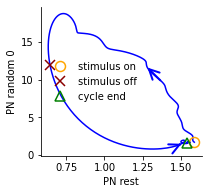

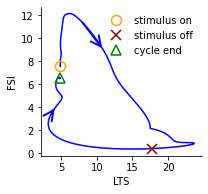

In [45]:
leg_loc = 'best'
# leg_loc = 'lower left'

for i, show_assy in show_assy_ids.items():
    for j in range(show_off):
        print(('Off' if j else 'On') + f' Cycle {i:d}')
        da = PN_grp_rspk_cyc_avg[j].mean_.sel(unique_cycle=i)
        rspk = {PN_group_names[a]: da.sel(assembly=a) for a in show_assy}
        da = pop_rspk_cyc_avg[j].mean_.sel(unique_cycle=i)
        if savefig:
            figsize = (3, 2.8)
            yl, xl = list(rspk)[:2]
            fig1, axs = plot.trajectory_pairplot(rspk, time=t_cyc, xlabels=[xl], ylabels=[yl],
                                                 figsize=figsize, **marker_kwargs)
            axs[0, 0].legend(loc=leg_loc, frameon=False)
            rspk = {p: da.sel(population=p) for p in ITN_pop_names}
            yl, xl = list(rspk)[:2]
            fig2, axs = plot.trajectory_pairplot(rspk, time=t_cyc, xlabels=[xl], ylabels=[yl],
                                                 figsize=figsize, **marker_kwargs)
            axs[0, 0].legend(loc=leg_loc, frameon=False)

            fig_name = 'Traj-' + trial_label
            plot.savefig(fig1, fig_name + '_PN', dir=fig_dir)
            plot.savefig(fig2, fig_name + '_ITN', dir=fig_dir)
        else:
            rspk.update({p: da.sel(population=p) for p in ITN_pop_names})
            _, axs = plot.trajectory_pairplot(rspk, time=t_cyc, **marker_kwargs)
        plt.show()

### Dispersion of population activities

In [46]:
only_stim = True  # Consider only stimulated assemblies
load_from_file = True  # Load from data files created by Analyze_FR_STP

PN_node_ids = np.concatenate([pop_ids[p] for p in PN_pop_names])

if load_from_file:
    import analysis.pipelines.population_spikes as ps
    
    ps.set_variables(RESULT_PATH=RESULT_PATH, OUTPUT_PATH=OUTPUT_PATH)
    PN_spk_file, _ = ps.get_file(TRIAL_NAME)
    if os.path.isfile(PN_spk_file): 
        with np.load(PN_spk_file) as f:
            unit_rspk = f['unit_fr']
    else:
        raise FileNotFoundError(f"Data file {PN_spk_file:s} not created")
else:
    from scipy.interpolate import interp1d

    fs_fr = 50.  # Hz. firing rate sampling frequency
    fs_ct = fs  # Hz. spike count sampling frequency
    filt_sigma = 20.0  # ms. Gaussian filer sigma

    # time bins
    time_ct_edge = np.linspace(0, 1000 * t_stop, int(t_stop * fs_ct), endpoint=False)
    time_ct = time_ct_edge + 1000 / fs_ct / 2

    time_fr = np.linspace(0, 1000 * t_stop, int(t_stop * fs_fr), endpoint=False)
    time_fr = time_fr + 1000 / fs_fr / 2
    time_fr = time_fr[(time_fr >= time_ct[0]) & (time_fr <= time_ct[-1])]

    # Unit firing rates
    unit_fr = process.unit_spike_rate_to_xarray(spikes_df, time_ct_edge,
        PN_node_ids, frequeny=True, filt_sigma=filt_sigma)
    unit_rspk = interp1d(time_ct, unit_fr, axis=1, assume_sorted=True)(time_fr)

# Assembly direction vectors of assemblies
PN_idx = pd.Series(range(len(PN_node_ids)), index=PN_node_ids)
assy_dvec = np.zeros((len(assy_ids) if only_stim else n_assy, PN_idx.size))
for i, ids in enumerate(assy_ids.values() if only_stim else Assembly_ids):
    assy_dvec[i, PN_idx[ids]] = 1
inactive_units = ~np.any(unit_rspk, axis=1)
assy_dvec[:, inactive_units] = 0  # remove inactivate units

if only_stim:
    assy_ids_disp = range(len(assy_ids))
    assy_names_disp = [assy_names[a] for a in assy_ids]

In [47]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

N_assy = assy_dvec.shape[0]

n_components = N_assy + 1
pca = PCA(n_components=n_components)
pca.fit(unit_rspk.T)

# Cosine similarity between PCs and assembly direction vectors
cosvec_mat = np.abs(cosine_similarity(pca.components_, assy_dvec))
cosvec = pd.DataFrame(cosvec_mat[:, assy_ids_disp], columns=assy_names_disp,
                      index=pd.Index(range(pca.components_.shape[0]), name='PCs'))
cosvec['max'] = cosvec.max(axis=1)
cosvec['max_group'] = [cosvec.columns[i] for i in np.argmax(cosvec.values, axis=1)]
cosvec['total projection'] = np.linalg.norm(cosvec_mat, axis=1)
assy2pc_proj = np.linalg.norm(cosvec_mat[:N_assy], axis=0)

P_angles, Gr_dist = metric.principal_angles(pca.components_[:N_assy], assy_dvec, rowspace=True)

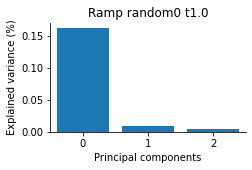

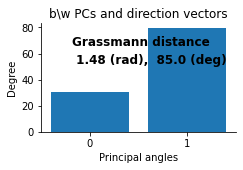

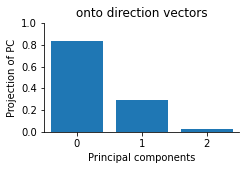

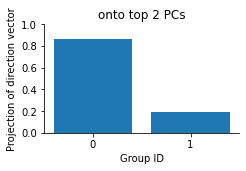

In [48]:
figsize = (3.5, 2) if N_assy < 5 else (4.5, 2.5)
# Explained variance
X = np.arange(n_components)
fig1 = plt.figure(figsize=figsize)
plt.bar(X, pca.explained_variance_ratio_)
plt.xlim(X[[0, -1]] + np.array([-0.5, 0.5]))
plt.xticks(X)
plt.xlabel('Principal components')
plt.ylabel('Explained variance (%)')
plt.title(trial_label)

# Distance between PC subspace and assembly subspace
X = np.arange(len(P_angles))
fig2 = plt.figure(figsize=figsize)
plt.bar(X, 180 / np.pi * P_angles)
text_kwargs = dict(transform=plt.gca().transAxes, fontsize='large', fontweight='bold',
                   horizontalalignment='right', verticalalignment='top')
plt.text(0.95, 0.88, 'Grassmann distance    ', **text_kwargs)
plt.text(0.95, 0.72, '%5.2f (rad), %5.1f (deg)' % (Gr_dist, 180 / np.pi *  Gr_dist), **text_kwargs)
plt.xlim(X[[0, -1]] + np.array([-0.5, 0.5]))
plt.xticks(X)
plt.xlabel('Principal angles')
plt.ylabel('Degree')
plt.title('b\w PCs and direction vectors')

# Projection of PCs and assembly directions onto the each other's subspace
X = np.arange(n_components)
fig3 = plt.figure(figsize=figsize)
plt.bar(X, cosvec['total projection'])
plt.xlim(X[[0, -1]] + np.array([-0.5, 0.5]))
plt.ylim(0, 1)
plt.xticks(X)
plt.xlabel('Principal components')
plt.ylabel('Projection of PC')
plt.title('onto direction vectors')

X = np.arange(N_assy)
fig4 = plt.figure(figsize=figsize)
if isdivision:
    for i, ids in assy_div.items():
        plt.bar(ids, assy2pc_proj[ids], label=str(i))
    plt.legend(title='intrinsic assembly', loc='upper right', framealpha=0.2)
else:
    plt.bar(X, assy2pc_proj)
plt.xlim(X[[0, -1]] + np.array([-0.5, 0.5]))
plt.ylim(0, 1)
plt.xticks(X)
plt.xlabel('Group ID')
plt.ylabel('Projection of direction vector')
plt.title(f'onto top {N_assy:d} PCs')

if savefig:
    for i, fig in enumerate([fig1, fig2, fig3, fig4]):
        plot.savefig(fig, 'PCA- ' + trial_label + f' -{i:d}', dir=fig_dir)

plt.show()

In [49]:
if not only_stim:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    assy_names_radar = assy_names_disp + [assy_names_disp[0]]
    PC_names_radar = [f'PC {i:d}' for i in range(n_components)]
    PC_names_radar = PC_names_radar + [PC_names_radar[0]]
    PC_idx_radar = list(range(n_components)) + [0]
    cmap = px.colors.sample_colorscale('thermal', np.linspace(0, 1, n_components))[::-1]
    if isdivision:
        cmap2 = px.colors.sample_colorscale('Rainbow', np.linspace(0, 1, \
            max(len(ids) for ids in assy_div.values())))[::-1]
    else:
        cmap2 = px.colors.sample_colorscale('Rainbow', np.linspace(0, 1, n_assy))[::-1]
    rotation = 130 if isdivision else 90
    maxcos = cosvec[assy_names_disp].values.max()

    fig = go.Figure()
    for i in range(n_components)[::-1]:
        fig.add_trace(go.Scatterpolar(
            name=PC_names_radar[i], r=cosvec.loc[i, assy_names_radar],
            theta=assy_names_radar, mode='lines', line_color=cmap[i]
        ))
    fig.update_polars(
        gridshape = 'linear',
        angularaxis = dict(rotation=rotation, direction="clockwise"),
        radialaxis = dict(angle=90, tickangle=90, nticks=4, range=(0, maxcos))
    )
    fig.update_layout(
        width=600, height=400, margin=dict(l=10, r=100, t=60, b=20),
        title = dict(text='Cosine similarity between PCs and assembly directions', x=0.5),
        legend = dict(traceorder='reversed', xanchor='left', x=1.0, y=0.5)
    )
    fig.show()

    if isdivision:
        n_int_assy = len(assy_div)
        fig = make_subplots(
            rows=1, cols=n_int_assy, specs=[[{'type': 'polar'}] * n_int_assy],
            subplot_titles=[f'intrinsic assembly {a:d}' for a in assy_div],
            horizontal_spacing=0.0
        )
        for i, ids in enumerate(assy_div.values()):
            for j in range(len(ids)):
                fig.add_trace(go.Scatterpolar(name=assy_names[ids[j]],
                    r=cosvec.loc[PC_idx_radar, assy_names[ids[j]]],
                    theta=PC_names_radar, mode='lines', line_color=cmap2[j],
                    legendgroup=i, legendgrouptitle_text=f'intrinsic assembly {i:d}'
                ), row=1, col=i + 1)
        fig.update_layout(width=1200, height=360, margin=dict(l=10, r=120, t=50, b=30))
        for annotation in fig['layout']['annotations']: 
            annotation['y'] = 1.08
    else:
        fig = go.Figure()
        for i in range(n_assy):
            fig.add_trace(go.Scatterpolar(name=assy_names_disp[i],
                r=cosvec.loc[PC_idx_radar, assy_names_disp[i]],
                theta=PC_names_radar, mode='lines', line_color=cmap2[i]
            ))
        fig.update_layout(width=600, height=400, margin=dict(l=10, r=100, t=40, b=40))
    fig.update_polars(
        gridshape = 'linear',
        angularaxis = dict(rotation=90, direction="clockwise"),
        radialaxis = dict(angle=90, tickangle=90, nticks=4, range=(0, maxcos))
    )
    fig.update_layout(legend=dict(xanchor='left', x=1.0, y=0.5))
    fig.show()

In [50]:
print("Alignment (cosine similarity) between PCs and assembly directions")
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(cosvec)

Alignment (cosine similarity) between PCs and assembly directions


,random 0,rest,max,max_group,total projection
PCs,,,,,
0,0.825,0.105,0.825,random 0,0.832
1,0.241,0.162,0.241,random 0,0.290
2,0.028,0.009,0.028,random 0,0.029
